In [1]:
from itertools import chain
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import subprocess
from pathlib import Path

In [2]:
from ghapi.all import GhApi, paged, gh2date
from tqdm.notebook import tqdm

with open('/Users/seth/.config/ghapi-token') as f:
    token = f.read().strip()

celer = GhApi(owner='celeritas-project', repo='celeritas', token=token)

## Star history

In [7]:
def get_stars(repo):
    star_props = chain.from_iterable(paged(
        repo.activity.list_stargazers_for_repo,
        headers=dict(accept='application/vnd.github.star+json')
    ))
    stardate = sorted([gh2date(p['starred_at']) for p in star_props])
    stars = pd.Series(np.arange(len(stardate), dtype=int),
                  index=pd.DatetimeIndex(stardate))
    return stars

In [8]:
celer_stars = get_stars(celer)
adept_stars = get_stars(GhApi(owner='apt-sim', repo='AdePT', token=token))

In [9]:
stars = pd.DataFrame({'celeritas': celer_stars, 'adept': adept_stars})

In [12]:
stars.fillna(method='pad', inplace=True)

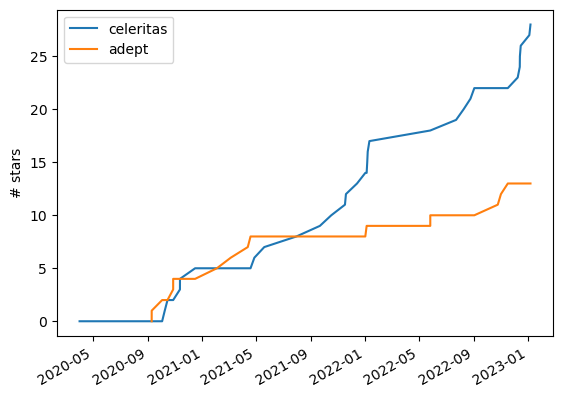

In [15]:
ax = stars.plot(ylabel='# stars')

## Release note generation

In [55]:
RELEASE = '0.2.0'
PREV_RELEASE = '0.1.4'
TARGET_BRANCH = 'upstream/master'

Option 1 (less accurate): use official release notes

In [3]:
RE_GET_PULL = re.compile(r'by @[\w]+ in https://.*/pull/(\d+)$')

def parse_release_pulls(text):
    result = []
    for line in text.splitlines():
        match = RE_GET_PULL.search(line)
        if match:
            result.append(int(match.group(1)))
    return result

notes = celer.repos.generate_release_notes(
    tag_name="v" + RELEASE, previous_tag_name="v" + PREV_RELEASE)['body']

pull_ids = parse_release_pulls(notes)

Option 2: parse subject lines

In [36]:
RE_SUBJECT_PR = re.compile(r'\(#([\d]+)\)$')
GIT = 'git'
CELERITAS_REPO = Path("/Users/seth/.local/src/celeritas")

def git(*args, split=b'\n'):
    result = subprocess.check_output(('git',) + args,
                                     env={'GIT_DIR': str(CELERITAS_REPO / ".git")})
    return [s.decode() for s in result.split(split)]

def parse_log_pulls(logs):
    for line in logs:
        match = RE_SUBJECT_PR.search(line)
        if match:
            yield int(match.group(1))
        elif line:
            print("No PR ID on commit:", line)
            
def git_log_subjects(start, stop):
    return git('log', '--format=%s', start + '..' + stop)[:-1]

In [57]:
merge_base = git('merge-base', TARGET_BRANCH, 'v' + PREV_RELEASE)[0]
exclude_ids = set(parse_log_pulls(git_log_subjects(merge_base, "v" + PREV_RELEASE)))

No PR ID on commit: Add release notes
No PR ID on commit: Add release notes and update documentation
No PR ID on commit: Escape rather than segfault on geometry error in release mode
No PR ID on commit: Fix ignoring of 'rayleigh' bool flag
No PR ID on commit: Add release docs for v0.1.2


In [58]:
exclude_ids |= {516} # Add any PRs with missing IDs above here
pull_ids = [p for p in parse_log_pulls(git_log_subjects(merge_base, TARGET_BRANCH))
            if p not in exclude_ids][::-1]

In [59]:
categories = ['enhancement', 'bug', 'documentation', 'housekeeping']
category_titles = ["New features", "Bug fixes", "Documentation improvements", "Minor internal changes"]

sorted_pulls = defaultdict(list)
for pr_id in tqdm(pull_ids):
    p = celer.pulls.get(pr_id)
    reviews = celer.pulls.list_reviews(pr_id)
    labels = {l.name for l in p['labels']}
    summary = {
        "id": pr_id,
        "title": p['title'],
        "labels": labels,
        "author": p['user']['login'],
        "reviewers": {r['user']['login'] for r in reviews if r['state'] == 'APPROVED'},
        "merged_at": gh2date(p.merged_at),
    }
    for lab in categories:
        if lab in labels:
            sorted_pulls[lab].append(summary)
            break
    else:
        print("Missing label:", pr_id, p['title'], labels)
        sorted_pulls['missing'].append(summary)

  0%|          | 0/74 [00:00<?, ?it/s]

Missing label: 551 Add CMakePresets and env script for perlmutter {'infrastructure'}
Missing label: 566 CI: use Geant4 11, C++17, VecGeom 1.2, CUDA 11.8, GCC 11 {'infrastructure'}
Missing label: 573 Restrict where CUDA CI builds can run {'infrastructure'}
Missing label: 569 CI: add no-debug HIP (ROCM 5.4) build {'infrastructure'}
Missing label: 584 Add clang address sanitizer to CI {'infrastructure'}


In [60]:
notes = [
    f"""
Version {RELEASE}
=============

Version {RELEASE} enables new coupled integration between Celeritas and Geant4
using the Acceleritas interface library. It features new ROOT output capabilities
including MC truth output, a set of high-level API classes for integrating
into existing Geant4 toolkit-based apps, and better support for multithreaded use.
"""
]

for (lab, title) in zip(categories, category_titles):
    notes.extend([title, "-" * len(title), ""])
    reviews = defaultdict(int)
    for pr in sorted_pulls[lab]:
        notes.append("* {title} *(@{author}, #{id})*".format(**pr))
        for r in pr['reviewers']:
            reviews[r] += 1
    
    notes.append("")
    notes.append("Reviewers: " + ", ".join(f"@{k} *({reviews[k]})*"
                                           for k in sorted(reviews, key=reviews.__getitem__, reverse=True)))
    notes.append("")
    
notes.append(f"""\
**Full Changelog**: https://github.com/celeritas-project/celeritas/compare/v{PREV_RELEASE}...v{RELEASE}
""")

In [61]:
print("\n".join(notes))


Version 0.2.0

Version 0.2.0 enables new coupled integration between Celeritas and Geant4
using the Acceleritas interface library. It features new ROOT output capabilities
including MC truth output, a set of high-level API classes for integrating
into existing Geant4 toolkit-based apps, and better support for multithreaded use.

New features
------------

* Export SB, Livermore PE, and atomic relaxation data to ROOT file *(@stognini, #481)*
* Refactor ORANGE input to be more extensible *(@sethrj, #510)*
* Make primary generator more general *(@amandalund, #514)*
* Support arbitrary user/internal kernels as part of stepping loop *(@sethrj, #525)*
* Improve CMake version/host metadata *(@sethrj, #529)*
* Baby steps toward Geant4 integration *(@sethrj, #531)*
* Add "background" volume support to ORANGE *(@sethrj, #530)*
* Build Livermore/SB data from ImportedData *(@sethrj, #535)*
* Load and build multiple universes in ORANGE *(@elliottbiondo, #534)*
* Support adding primaries at any ste

## Add missing PR labels in bulk

In [19]:
fixup = {
#    'bug': "516 527 558",
#    'enhancement': "510 552 575 576 580 585",
#    'housekeeping': "520 ",
#    'infrastructure': "551 573",
}
for (label, pullstr) in fixup.items():
    for pr_id in pullstr.split():
        celer.issues.add_labels(int(pr_id), [label])